In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

movies_df = pd.read_csv(r'C:\Users\Administrator\Desktop\Studies\Python\Python_Project_Movie_Analysis\Python_Project_Movie_Analysis\0_Dataset\movies_metadata.csv', low_memory= False)

movies_df['release_date'] = pd.to_datetime(movies_df['release_date'],errors='coerce') # Convert data type of release_date to datetime.
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce') # Convert data type of budget to numeric.


def list_name(string_list_dict): # Convert the string list of dictionary into list of name.
    list_dict = ast.literal_eval(string_list_dict) if pd.notna(string_list_dict) else string_list_dict
    return [dict['name'] for dict in list_dict] if isinstance(list_dict,list) else []

movies_df['genres'] = movies_df['genres'].apply(lambda x: list_name(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: list_name(x))
movies_df['production_countries'] = movies_df['production_countries'].apply(lambda x: list_name(x))

movies_df = movies_df.explode('production_countries')
movies_df_US = movies_df[(movies_df['production_countries'] == "United States of America") & (movies_df['release_date'].dt.year > 2000)].copy() # Filtering all the movies that was produced in United States.

movies_df_US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9529 entries, 2564 to 45463
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  9529 non-null   object        
 1   belongs_to_collection  1247 non-null   object        
 2   budget                 9529 non-null   float64       
 3   genres                 9529 non-null   object        
 4   homepage               3726 non-null   object        
 5   id                     9529 non-null   object        
 6   imdb_id                9528 non-null   object        
 7   original_language      9528 non-null   object        
 8   original_title         9529 non-null   object        
 9   overview               9516 non-null   object        
 10  popularity             9529 non-null   object        
 11  poster_path            9482 non-null   object        
 12  production_companies   9529 non-null   object        
 13  prod

# Exploratory Data Analysis

## Top-rated Movies


Filter movies with a vote count greater than 1000, then identify those with the highest average ratings.

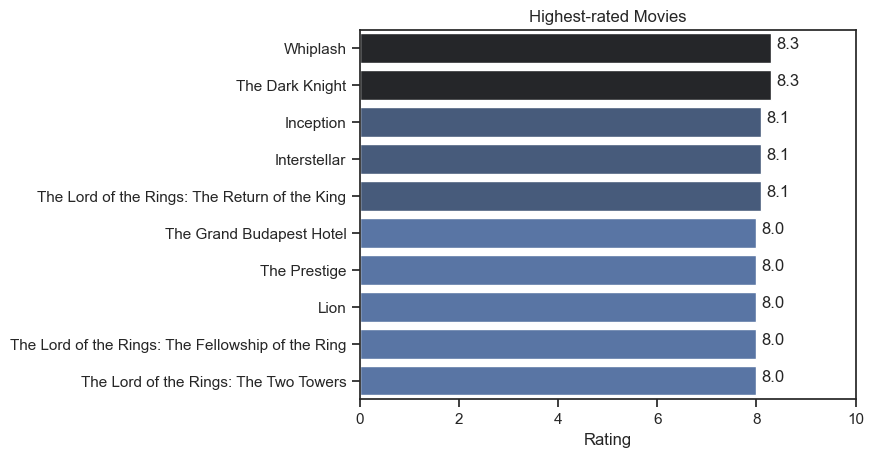

In [24]:
movies_high_vote = movies_df_US[movies_df_US['vote_count'] > 1000] # Focus on movies with voutcount morethat 1000
movies_high_vote = movies_high_vote.sort_values('vote_average', ascending= False).head(10)

sns.barplot(
    data= movies_high_vote
    ,x= 'vote_average'
    ,y= 'title'
    ,hue= 'vote_average'
    ,palette= 'dark:b_r'
    ,legend= False
    )
sns.set_theme(style= 'ticks')
ax = plt.gca()
ax.set_xlabel('Rating')
ax.set_ylabel('')
ax.set_xlim(0,10)
ax.set_title('Highest-rated Movies')

for i,vote in enumerate(movies_high_vote['vote_average']):
    ax.text(vote+.1,i,vote)

## Revenue vs Budget

Identify if there's a relationship between a movie’s budget and its box office revenue.

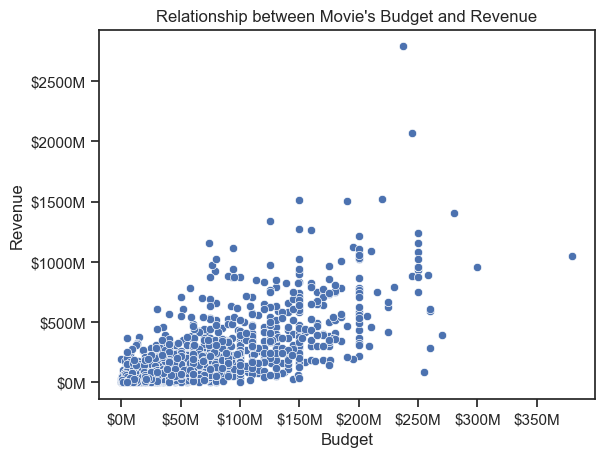

In [97]:
movies_revenue_budget = movies_df_US[(movies_df_US['revenue'] > 0) & (movies_df_US['budget'] > 0)].copy() # filter out movies without revenue and budget stated.

sns.scatterplot(
    data= movies_revenue_budget
    ,x= 'budget'
    ,y= 'revenue'
)
ax = plt.gca()
ax.set_title("Relationship between Movie's Budget and Revenue")
ax.set_xlabel('Budget')
ax.set_ylabel('Revenue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, i: f'${x/1_000_000:.0f}M'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, i: f'${y/1_000_000:.0f}M'))

## Ratings Over Time

See how movie ratings have evolved over the years.

Text(0.5, 1.0, 'Movies Rating Over the Year')

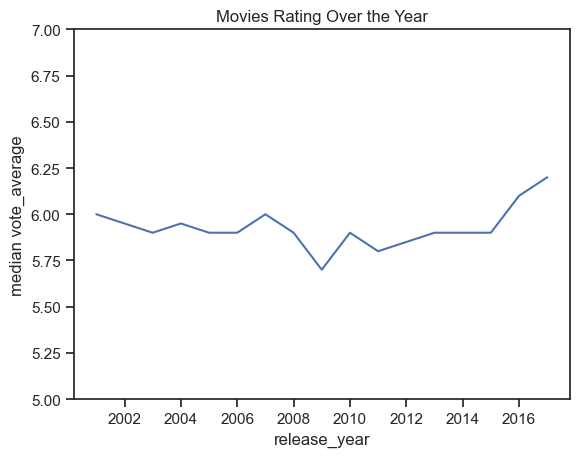

In [95]:
movies_vote = movies_df_US[movies_df_US['vote_average'] > 0].copy()
movies_vote['release_year'] = movies_vote['release_date'].dt.year
movies_release_year = movies_vote.groupby(['release_year']).agg(median_vote = ('vote_average','median'))

sns.lineplot(
    data= movies_release_year
    ,x= 'release_year'
    ,y= 'median_vote'
    )
plt.ylim(5,7)
plt.ylabel('median vote_average')
plt.title('Movies Rating Over the Year')

See movie genres size over time

<Axes: xlabel='release_year'>

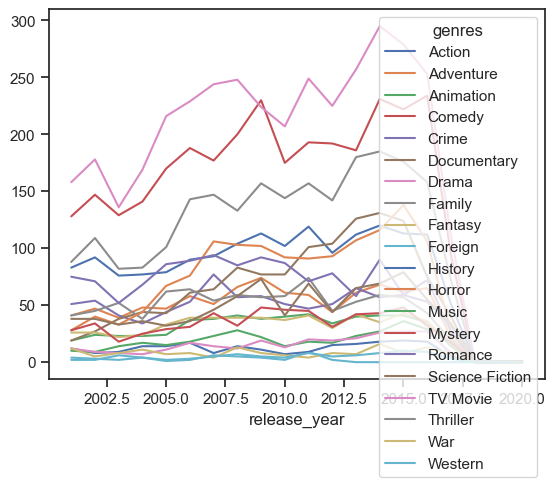

In [105]:
movies_genres = movies_df_US.explode(['genres'])
genres_pivot = movies_genres.pivot_table(columns='genres',index='release_year',aggfunc= 'size').fillna(0)

genres_pivot.plot(kind= 'line')